In [1]:
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from wordcloud import ImageColorGenerator
from IPython.display import HTML, Markdown, display
from mlxtend.frequent_patterns import association_rules, fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from utility import CASE, METHO, VALID, check_job_title, clean_skills, init_jobs

In [2]:
warnings.filterwarnings("ignore")

In [3]:
HTML(
    """
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
"""
)

# HIRING DETECTIVE: unmasking key patterns in LinkedIn job postings with frequent itemset mining

# Abstract

xxx

# Introduction

Job and head hunting have been there for eons since humans have formed structured societies and developed economic activities. Historically, job hunting often involved informal networks, word of mouth, and local community connections. As societies became more complex and economies diversified, formal job markets and centralized systems for recruitment emerged.

In recent decades, with technology and globalization, job hunting and headhunting have become more sophisticated. Online job boards, professional networking platforms, and recruitment agencies have transformed the way people search for jobs and employers find talent.

But even with improvements to match prospective employees to employers, a problem has been lingering for years, especially with the pandemic that took place.

# Motivation

“Skill-gap” (citation) is the difference in skills required on the job and the actual skills possessed by the employees. Through time, the skill gap continues to widen, due to the fact that jobs evolve faster than the training and education that the people does to learn the skill.

The implications of the skill-gap extend beyond individual companies and their workforce. It impacts the economic activities of entire nations. When there is a misalignment between the skills demanded by the job market and the skills available within the workforce, it results in inefficiencies, decreased productivity, and economic stagnation.


According to an article of hbr(citation), employers started to switch their requirements from degrees and focus instead on skills, this is not to lower the entry skills but adapt to changes. With this skill based hiring, prospective employees can learn new skills that will help them land a job.

From a study made by the National Skills Coalition of America in 2018, shown in figure 1 below, according to them a large number of the workforce have skills that is not match to the jobs available. 

# Statement of the Problem

The job skill mismatch dilemma presents a significant challenge, causing inefficiencies in hiring processes. To mitigate this, a streamlined solution is needed to recommend skills for enhancing applicant hirability and enabling employers to efficiently select and rank candidates with the help of frequent itemset mining (fim) association rules.

# Scope and Limitations of the Study

Our study relies on data extracted in the first quarter of 2024, emphasizing its recency and relevance to our analysis. The data is considered fresh but is limited to not incorporate any updates beyond its extraction. Such as the skillsets and job postings are limited to the date of extraction.

The study only focuses on data science jobs and other allied jobs, such jobs are the Data Engineers, Data Analyst, Data Tech and others that are to be defined in the methodology.

Use cases will only on employee and employer scenarios

Despite a lot of features a job posting has, the skills that are listed by employeers are the items that are to be part of the study. Other features such as years of experience, education level and also job levels were not included in the study due to it unavailable in the data or there is difficulty in extraction and is still beyond the capabilities of the Learning Team.

# Dataset Overview

The LinkedIn dataset contains 12,217 job postings focusing exclusively on tech job opportunities. Each entry in the dataset offers detailed information, including job titles, company profiles, geographical locations, and relevant search parameters.

The LinkedIn dataset, extracted from Kaggle, comprises three distinct CSV files: job_postings.csv, job_skills.csv, and job_summary.csv. The three files were merged using the "job_link" column.

There are no null or NaN rows in the dataset, hence no data imputation or rows were dropped.

In [4]:
merged_df = init_jobs()
merged_df.info()
display(Markdown("**Figure 1**. Dataset info - no nulls"))

12217

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12217 entries, 0 to 12216
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_link             12217 non-null  object
 1   job_summary          12217 non-null  object
 2   last_processed_time  12217 non-null  object
 3   last_status          12217 non-null  object
 4   got_summary          12217 non-null  object
 5   got_ner              12217 non-null  object
 6   is_being_worked      12217 non-null  object
 7   job_title            12217 non-null  object
 8   company              12217 non-null  object
 9   job_location         12216 non-null  object
 10  first_seen           12217 non-null  object
 11  search_city          12217 non-null  object
 12  search_country       12217 non-null  object
 13  search_position      12217 non-null  object
 14  job_level            12217 non-null  object
 15  job_type             12217 non-null  object
 16  job_

**Figure 1**. Dataset info - no nulls

After merging the dataframes, the following columns were used:
1. **job_link** - actual job link of the job posting
2. **job_title** - full job title of the job opening (Ex. Senior Data Warehouse Developer/ Architect)
3. **job_skills** - list of skills needed for the job opening

To standardize the job titles, the team implemented a categorization system for common roles like 'Data Scientist', 'Data Analyst', etc. 

Examples:
1. 'Senior Machine Learning Engineer' will be categorized as 'Machine Learning Engineer'.
2. 'Staff Data Scientist, Financial Strategy' will be categorized as 'Data Scientist'.
3. 'Senior ETL Data Warehouse Specialist' will be categorized as 'Data Engineer'.

note: sample job_titles are present in our actual database 

This categorization process also disregarded job level indicators present in the titles, such as 'senior', 'junior', or 'associate'. Furthermore, given the higher number of 'Mid senior' roles compared to 'Associate' positions, the team opted not to differentiate between various job levels.

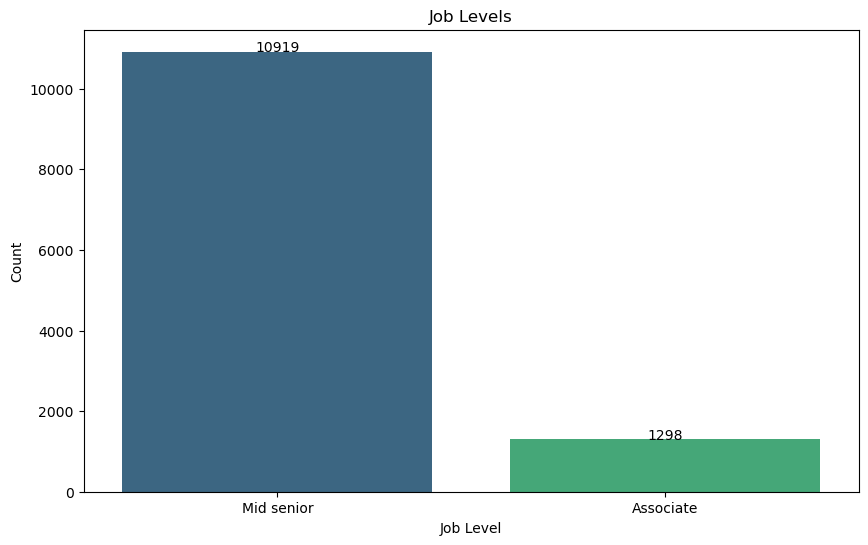

**Figure 2**. Job levels by seniority

In [5]:
job_level_counts = merged_df['job_level'].value_counts().reset_index()
job_level_counts.columns = ['Job Level', 'Count']

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=job_level_counts, x='Job Level', y='Count', palette='viridis')
plt.title('Job Levels')
plt.xlabel('Job Level')
plt.ylabel('Count')

# Annotate bars with counts
for index, row in job_level_counts.iterrows():
    ax.text(row.name, row['Count']+0.2, row['Count'], color='black', ha="center")

plt.show()
display(Markdown("**Figure 2**. Job levels by seniority"))

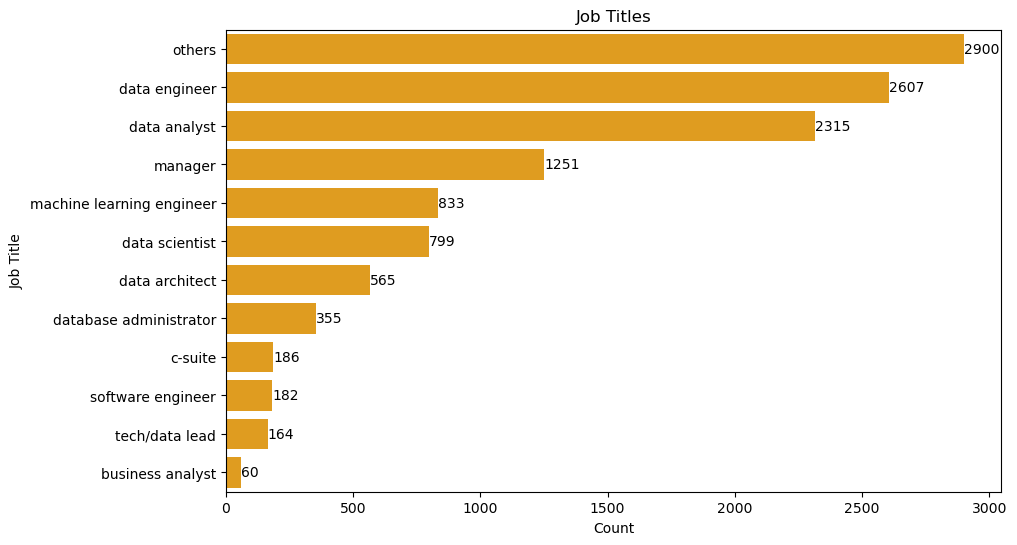

**Figure 3**. Count of binned jobs

In [6]:
merged_df["job_title_new"] = merged_df["job_title"].apply(check_job_title)
job_title_counts = merged_df['job_title_new'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.countplot(data=merged_df, y='job_title_new', order=job_title_counts.index, color='orange')
plt.title('Job Titles')
plt.xlabel('Count')
plt.ylabel('Job Title')

for i, count in enumerate(job_title_counts):
    ax.text(count, i, str(count), ha='left', va='center')

plt.show()
display(Markdown("**Figure 3**. Count of binned jobs"))

In [7]:
merged_df["job_skills_"] = merged_df["job_skills"].apply(clean_skills)
list_of_lists = merged_df["job_skills_"].to_list()
list_of_words = [item for sublist in list_of_lists for item in sublist]

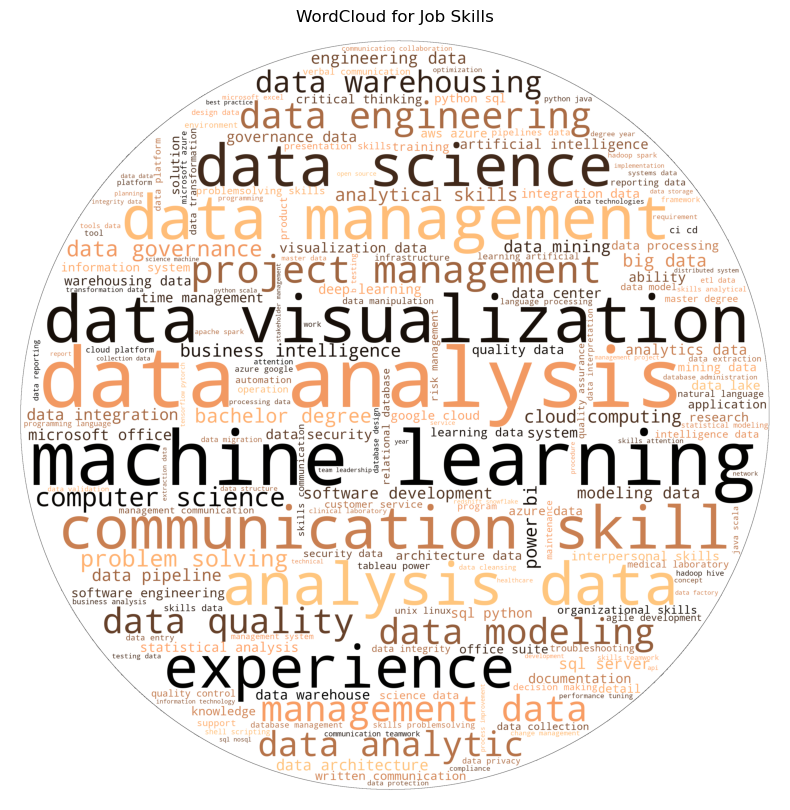

**Figure 4**. Wordcloud of relevant skills in the main transaction database

In [8]:
mask = np.array(Image.open('images/circle_PNG14.png'))
colors = ImageColorGenerator(mask)
wordcloud = WordCloud(
    mask=mask,
    stopwords=set(STOPWORDS),
    contour_width=0.1,
    contour_color='black',
    min_font_size=3,
    background_color='white',
    colormap='copper'
).generate(' '.join(list_of_words))

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis("off")
plt.title("WordCloud for Job Skills")
plt.show()
display(Markdown("**Figure 4**. Wordcloud of relevant skills in the main transaction database"))

# Methodology

## Merged Dataframe

Prepared input CSVs to a merged dataframe for processing

In [9]:
merged_df = init_jobs()

12217

## Jobs binning

Binning jobs for selection later when cases are created where one person wants to transition into one of the binned roles.

In [10]:
merged_df["job_title_new"] = merged_df["job_title"].apply(check_job_title)
merged_df["job_title_new"].value_counts()

job_title_new
others                       2900
data engineer                2607
data analyst                 2315
manager                      1251
machine learning engineer     833
data scientist                799
data architect                565
database administrator        355
c-suite                       186
software engineer             182
tech/data lead                164
business analyst               60
Name: count, dtype: int64

create new column `job_skills_` list of skills for the job

In [11]:
merged_df["job_skills_"] = merged_df["job_skills"].apply(clean_skills)

Bin job titles into these job titles:
- data engineer 
- data scientist 
- data analyst 
- business analyst 
- database engineer 
- database administrator 
- data architect 
- machine learning/mlops engineer 
- software engineer 
- tech lead 

## Base Transaction Database

This will be the base database for filtering later when we filter by job title.

In [12]:
display(merged_df[["job_link", "job_title_new", "job_skills_"]].head(6))
display(Markdown("**Table 1**. Base Transaction Database"))

,job_link,job_title_new,job_skills_
0,https://www.linkedin.com/jobs/view/senior-mach...,machine learning engineer,"[machine learning, programming, python, scala,..."
1,https://www.linkedin.com/jobs/view/principal-s...,software engineer,"[c++, python, pytorch, tensorflow, mxnet, cuda..."
2,https://www.linkedin.com/jobs/view/senior-etl-...,data engineer,"[etl, data integration, data transformation, d..."
3,https://www.linkedin.com/jobs/view/senior-data...,data architect,"[data lakes, data bricks, azure data factory p..."
4,https://www.linkedin.com/jobs/view/lead-data-e...,data engineer,"[java, scala, python, rdbms, nosql, redshift, ..."
5,https://www.linkedin.com/jobs/view/senior-data...,data engineer,"[data warehouse (dw), extract/transform/load (..."


**Table 1**. Base Transaction Database

## Using FIM to recommend skills

In this project we'll be using FIM to recommend skills to a person given a base skillset. To recommend we will first create the frequent itemset using `fpgrowth` in `mlexted` library using `mlextend.fpgrowth` function and then getting associated association rules using `mlexted.association_rules` function. From the association rules, we will filter the antecedents based on the input base skills, order the rules by most lift and get top consequents that is unique and not already in the input base skills. We will then define a validation process below.

\begin{align}
\text{Probability to get job} &= \frac{\text{no. skills matched}}{\text{no. skills required by job}} \\
\text{Hirability} &= \text{Probability of getting any jobs in the current DB} = \frac{\sum_{i=1}^{n}\text{Probability to get job}_i}{\text{total transactions in DB (n)}}
\end{align}

**Equation 1 and 2**. Hirability Calculation

We'll quote the above metric as $Hirability$ based on what skills you have. $Hirability$ will be then compared for:
- Base Case (base skills only)
- Stochastic Case (add n randomly sourced skills)
- FIM Case (add n skills with most lift in the association rules)

In this project we'll be using Base Case as the baseline. Stochastic case as the "usual" method of expanding skills (in real life this is not entirely true but we'll use this as some kind of a PCC metric that will define your hirability by adding random skills). Finally, FIM case will be the alternative case. We will then check with the sample cases below the performance of all 3 based on their computed $Hirability$.

In [13]:
def skill_fim(merged_df, job_tit, support):
    """Get fim"""
    print(f"Wanting to transition to {job_tit}...")
    db = merged_df[merged_df["job_title_new"] == job_tit]
    dataset = db["job_skills_"].to_list()
    print(f"Size of DB: {len(dataset)}")
    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(df, min_support=support, use_colnames=True)

    rules = association_rules(frequent_itemsets, metric="lift")
    rules = rules[rules["antecedents"].isin(frequent_itemsets["itemsets"].to_list())]
    rules["a_cnt"] = rules["antecedents"].apply(len)
    rules["c_cnt"] = rules["consequents"].apply(len)
    rules = rules.sort_values(by=["c_cnt", "lift", "support"], ascending=False)
    return rules, frequent_itemsets, db

In [14]:
def get_skills_probability(job_database, skills_to_match):
    """Get skills probability"""
    job_database["acceptance_prob"] = job_database["job_skills_"].apply(
        lambda x: len(skills_to_match.intersection(x)) / len(x)
    )
    prob = round((job_database["acceptance_prob"].sum() / len(job_database)) * 100, 4)
    return prob, job_database["acceptance_prob"].sum(), len(job_database)

In [15]:
def test_fim(merged_df, job_tit, supp, base_skills, no_skills_to_add, fig_nos, case):
    """Create cases"""
    c_rules, c_fi, c_db = skill_fim(merged_df, job_tit, supp)
    display(Markdown(f"{job_tit.upper()} frequent itemset:"))
    display(c_fi)
    display(Markdown(f"**Table {fig_nos[0]}**. Frequent itemset {case}"))
    display(Markdown("Search frequent itemset if base skill in it:"))
    display(c_fi[c_fi["itemsets"] <= base_skills])
    display(Markdown(f"**Table {fig_nos[1]}**. Base skills in frequent itemset {case}"))
    display(
        Markdown(
            METHO.format(
                base_skills,
                base_skills,
                no_skills_to_add,
                base_skills,
                no_skills_to_add,
            )
        )
    )

    display(Markdown("### Base Case"))
    prob, job_cnt, job_total = get_skills_probability(c_db, base_skills)
    print(
        CASE.format(
            base_skills,
            prob,
            round(job_cnt),
            job_total,
            job_total,
            job_tit,
            round(job_cnt),
        )
    )
    base = prob

    display(Markdown("### Stochastic Case"))
    display(
        Markdown(
            f"Get hirability when {no_skills_to_add} random skills are added to base case, have 100 iterations and get the average"
        )
    )
    prob_list = []
    for i in range(100):
        choice = set(
            [item for sublist in c_db["job_skills_"].tolist() for item in sublist]
        )
        random_skill = random.sample(list(choice), no_skills_to_add)
        skills_to_match = base_skills.union(random_skill)
        prob_list.append(get_skills_probability(c_db, skills_to_match)[0])
    average = sum(prob_list) / len(prob_list)
    print(
        CASE.format(
            f"{base_skills} plus {no_skills_to_add} random skills, 100 iterations then get average",
            round(average, 4),
            round(round(average * len(c_db) / 100)),
            len(c_db),
            len(c_db),
            job_tit,
            round(round(average * len(c_db) / 100)),
        )
    )
    stochastic = average

    display(Markdown("### FIM Case"))
    display(
        Markdown(
            f"From the association rules above get top {no_skills_to_add} skills consequents with highest lift and add to skills"
        )
    )
    most_lift = c_rules[
        c_rules["antecedents"].apply(lambda rules: rules <= base_skills)
    ].sort_values(by=["lift", "confidence"], ascending=False)
    display(most_lift)
    display(Markdown(f"**Table {fig_nos[2]}**. Association Rules by most lift and confidence {case}"))
    consequents = [list(fs) for fs in most_lift["consequents"].to_list()]
    fim_skills = []
    consequents_ = [item for sublist in consequents for item in sublist]
    [fim_skills.append(i) for i in consequents_ if i not in fim_skills]
    fim_skills = [i for i in fim_skills if i not in base_skills][:no_skills_to_add]
    fim_skills = base_skills.union(fim_skills)
    prob, job_cnt, job_total = get_skills_probability(c_db, fim_skills)
    print(
        CASE.format(
            fim_skills,
            prob,
            round(job_cnt),
            job_total,
            job_total,
            job_tit,
            round(job_cnt),
        )
    )
    fim = prob

    display(Markdown("### Validation"))
    display(Markdown(VALID.format(round(base, 4), round(stochastic, 4), round(fim, 4))))

In [16]:
def skill_fim2(merged_df, job_tit, support):
    # print(f"Wanting to transition to {job_tit}...")
    db = merged_df[merged_df["job_title_new"] == job_tit]
    dataset = db["job_skills_"].to_list()
    # print(f"Size of DB: {len(dataset)}")
    te = TransactionEncoder()
    te_ary = te.fit(dataset).transform(dataset)
    df = pd.DataFrame(te_ary, columns=te.columns_)
    frequent_itemsets = fpgrowth(df, min_support=support, use_colnames=True)

    rules = association_rules(frequent_itemsets, metric="lift")
    rules = rules[rules["antecedents"].isin(frequent_itemsets["itemsets"].to_list())]
    rules["a_cnt"] = rules["antecedents"].apply(len)
    rules["c_cnt"] = rules["consequents"].apply(len)
    rules = rules.sort_values(by=["c_cnt", "lift", "support"], ascending=False)
    return rules, frequent_itemsets, db

In [17]:
def test_fim2(merged_df, job_tit, supp, base_skills, no_skills_to_add):
    c_rules, c_fi, c_db = skill_fim2(merged_df, job_tit, supp)
    prob, job_cnt, job_total = get_skills_probability(c_db, base_skills)
    base = prob
    prob_list = []
    for i in range(100):
        choice = set(
            [item for sublist in c_db["job_skills_"].tolist() for item in sublist]
        )
        random_skill = random.sample(list(choice), no_skills_to_add)
        skills_to_match = base_skills.union(random_skill)
        prob_list.append(get_skills_probability(c_db, skills_to_match)[0])
    average = sum(prob_list) / len(prob_list)
    stochastic = average
    most_lift = c_rules[
        c_rules["antecedents"].apply(lambda rules: rules <= base_skills)
    ].sort_values(by=["lift"], ascending=False)
    # display(most_lift)
    consequents = [list(fs) for fs in most_lift["consequents"].to_list()]
    fim_skills = []
    consequents_ = [item for sublist in consequents for item in sublist]
    [fim_skills.append(i) for i in consequents_ if i not in fim_skills]
    fim_skills = [i for i in fim_skills if i not in base_skills][:no_skills_to_add]
    fim_skills_ = base_skills.union(fim_skills)
    prob, job_cnt, job_total = get_skills_probability(c_db, fim_skills_)
    fim = prob
    return prob, fim_skills

# Results and Discussion

Below we'll be showing 3 cases where we checkout the hirability comparison between base, stochastic and fim cases:
- Fresh Grad to Data Scientist|
- Data Engineer to Tech/Data Lead
- Database Administrator to Data Analyst

## Case 1 - Fresh Grad to Data Scientist
with basic python and numpy knowledge, wants to be Data scientist

In [18]:
base_skills = {"python", "pandas", "numpy"}
test_fim(
    merged_df=merged_df,
    job_tit="data scientist",
    supp=0.05,
    base_skills=base_skills,
    no_skills_to_add=6,
    fig_nos=[i for i in range(2, 5)],
    case="Case 1",
)

Wanting to transition to data scientist...
Size of DB: 799


DATA SCIENTIST frequent itemset:

,support,itemsets
0,0.829787,(python)
1,0.719650,(machine learning)
2,0.670839,(data science)
3,0.485607,(r)
4,0.384230,(data visualization)
...,...,...
1887,0.053817,"(sql, nlp)"
1888,0.065081,"(nlp, python, machine learning)"
1889,0.053817,"(nlp, data science, python)"
1890,0.052566,"(nlp, data science, machine learning)"


**Table 2**. Frequent itemset Case 1

Search frequent itemset if base skill in it:

,support,itemsets
0,0.829787,(python)
33,0.077597,(pandas)
70,0.073842,(numpy)
1273,0.071339,"(pandas, python)"
1872,0.071339,"(numpy, python)"
1873,0.063830,"(numpy, pandas)"
1877,0.061327,"(numpy, pandas, python)"


**Table 3**. Base skills in frequent itemset Case 1

Comparing Hirability for:
- base `{'numpy', 'pandas', 'python'}`
- `{'numpy', 'pandas', 'python'}` plus 6 random sampled skills without replacement
- `{'numpy', 'pandas', 'python'}` plus 6 unique skills recommended by fim with highest lift


### Base Case

Skillset: {'numpy', 'pandas', 'python'}
Hirability: 4.006%
Jobs available: 32/799
Applying in all 799 data scientist jobs, you are likely to get into 32



### Stochastic Case

Get hirability when 6 random skills are added to base case, have 100 iterations and get the average

Skillset: {'numpy', 'pandas', 'python'} plus 6 random skills, 100 iterations then get average
Hirability: 4.0927%
Jobs available: 33/799
Applying in all 799 data scientist jobs, you are likely to get into 33



### FIM Case

From the association rules above get top 6 skills consequents with highest lift and add to skills

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,a_cnt,c_cnt
22823,(numpy),"(pandas, python)",0.073842,0.071339,0.061327,0.830508,11.641689,0.056059,5.479099,0.986983,1,2
22822,"(pandas, python)",(numpy),0.071339,0.073842,0.061327,0.859649,11.641689,0.056059,6.598874,0.984323,2,1
22812,(numpy),(pandas),0.073842,0.077597,0.063830,0.864407,11.139694,0.058100,6.802722,0.982803,1,1
22813,(pandas),(numpy),0.077597,0.073842,0.063830,0.822581,11.139694,0.058100,5.220162,0.986804,1,1
22824,(pandas),"(numpy, python)",0.077597,0.071339,0.061327,0.790323,11.078381,0.055791,4.428998,0.986265,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...
22215,(python),(project management),0.829787,0.098874,0.078849,0.095023,0.961052,-0.003195,0.995745,-0.192308,1,1
14993,(python),"(mathematics, computer science)",0.829787,0.111389,0.087610,0.105581,0.947854,-0.004820,0.993506,-0.244265,1,2
22130,(python),"(leadership, machine learning)",0.829787,0.070088,0.055069,0.066365,0.946886,-0.003089,0.996013,-0.247863,1,2
16302,(python),(operations research),0.829787,0.071339,0.052566,0.063348,0.887989,-0.006631,0.991469,-0.425641,1,1


**Table 4**. Association Rules by most lift and confidence Case 1

Skillset: {'scikitlearn', 'sql', 'data science', 'numpy', 'python', 'machine learning', 'r', 'pandas', 'tensorflow'}
Hirability: 15.2374%
Jobs available: 122/799
Applying in all 799 data scientist jobs, you are likely to get into 122



### Validation

Result:
- 4.006 % Hirability (base)
- 4.0927 % Hirability (stochastic)
- 15.2374 % Hirability (fim)

Hirability increase better in fim case compared to stochastic case!


## Case 2 - Data Engineer to Tech Lead

In [19]:
base_skills = {"r", "python"}
test_fim(
    merged_df=merged_df,
    job_tit="data analyst",
    supp=0.05,
    base_skills=base_skills,
    no_skills_to_add=3,
    fig_nos=[i for i in range(5, 8)],
    case="Case 2",
)

Wanting to transition to data analyst...
Size of DB: 2315


DATA ANALYST frequent itemset:

,support,itemsets
0,0.640605,(data analysis)
1,0.583585,(sql)
2,0.348164,(tableau)
3,0.272138,(communication)
4,0.253132,(r)
...,...,...
726,0.060475,"(sql, data warehousing, data analysis)"
727,0.060907,"(sql, data warehousing, data visualization)"
728,0.056587,"(data analysis, data warehousing, data visuali..."
729,0.053132,"(sql, business analysis)"


**Table 5**. Frequent itemset Case 2

Search frequent itemset if base skill in it:

,support,itemsets
4,0.253132,(r)
18,0.383585,(python)
108,0.234125,"(r, python)"


**Table 6**. Base skills in frequent itemset Case 2

Comparing Hirability for:
- base `{'r', 'python'}`
- `{'r', 'python'}` plus 3 random sampled skills without replacement
- `{'r', 'python'}` plus 3 unique skills recommended by fim with highest lift


### Base Case

Skillset: {'r', 'python'}
Hirability: 2.7808%
Jobs available: 64/2315
Applying in all 2315 data analyst jobs, you are likely to get into 64



### Stochastic Case

Get hirability when 3 random skills are added to base case, have 100 iterations and get the average

Skillset: {'r', 'python'} plus 3 random skills, 100 iterations then get average
Hirability: 2.7923%
Jobs available: 65/2315
Applying in all 2315 data analyst jobs, you are likely to get into 65



### FIM Case

From the association rules above get top 3 skills consequents with highest lift and add to skills

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,a_cnt,c_cnt
5603,"(r, python)","(sql, a/b testing, tableau, data visualization)",0.234125,0.055292,0.052268,0.223247,4.037635,0.039323,1.216228,0.982315,2,4
5932,"(r, python)","(sql, a/b testing, tableau, data analysis)",0.234125,0.053132,0.050108,0.214022,4.028140,0.037669,1.204701,0.981553,2,4
5484,"(r, python)","(sql, a/b testing, tableau)",0.234125,0.057451,0.053564,0.228782,3.982188,0.040113,1.222156,0.977812,2,3
5841,"(r, python)","(a/b testing, tableau, data analysis)",0.234125,0.054428,0.050540,0.215867,3.966131,0.037797,1.205883,0.976485,2,3
5512,"(r, python)","(a/b testing, tableau, data visualization)",0.234125,0.057019,0.052700,0.225092,3.947641,0.039350,1.216894,0.974943,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
6055,(python),(project management),0.383585,0.200864,0.077754,0.202703,1.009154,0.000705,1.002306,0.014716,1,1
2751,(python),(reporting),0.383585,0.157235,0.060475,0.157658,1.002685,0.000162,1.000501,0.004345,1,1
3426,(python),(data management),0.383585,0.201728,0.077322,0.201577,0.999250,-0.000058,0.999811,-0.001216,1,1
6313,(python),(teamwork),0.383585,0.136069,0.050972,0.132883,0.976584,-0.001222,0.996325,-0.037442,1,1


**Table 7**. Association Rules by most lift and confidence Case 2

Skillset: {'sql', 'a/b testing', 'python', 'r', 'tableau'}
Hirability: 7.461%
Jobs available: 173/2315
Applying in all 2315 data analyst jobs, you are likely to get into 173



### Validation

Result:
- 2.7808 % Hirability (base)
- 2.7923 % Hirability (stochastic)
- 7.461 % Hirability (fim)

Hirability increase better in fim case compared to stochastic case!


## Case 3 - Database Administrator to Data Analyst

In [20]:
base_skills = {"sql", "linux", "oracle", "mssql", "mysql"}
test_fim(
    merged_df=merged_df,
    job_tit="data analyst",
    supp=0.05,
    base_skills=base_skills,
    no_skills_to_add=6,
    fig_nos=[i for i in range(8, 11)],
    case="Case 3",
)

Wanting to transition to data analyst...
Size of DB: 2315


DATA ANALYST frequent itemset:

,support,itemsets
0,0.640605,(data analysis)
1,0.583585,(sql)
2,0.348164,(tableau)
3,0.272138,(communication)
4,0.253132,(r)
...,...,...
726,0.060475,"(sql, data warehousing, data analysis)"
727,0.060907,"(sql, data warehousing, data visualization)"
728,0.056587,"(data analysis, data warehousing, data visuali..."
729,0.053132,"(sql, business analysis)"


**Table 8**. Frequent itemset Case 3

Search frequent itemset if base skill in it:

,support,itemsets
1,0.583585,(sql)


**Table 9**. Base skills in frequent itemset Case 3

Comparing Hirability for:
- base `{'mysql', 'oracle', 'sql', 'mssql', 'linux'}`
- `{'mysql', 'oracle', 'sql', 'mssql', 'linux'}` plus 6 random sampled skills without replacement
- `{'mysql', 'oracle', 'sql', 'mssql', 'linux'}` plus 6 unique skills recommended by fim with highest lift


### Base Case

Skillset: {'mysql', 'oracle', 'sql', 'mssql', 'linux'}
Hirability: 2.9831%
Jobs available: 69/2315
Applying in all 2315 data analyst jobs, you are likely to get into 69



### Stochastic Case

Get hirability when 6 random skills are added to base case, have 100 iterations and get the average

Skillset: {'mysql', 'oracle', 'sql', 'mssql', 'linux'} plus 6 random skills, 100 iterations then get average
Hirability: 3.0179%
Jobs available: 70/2315
Applying in all 2315 data analyst jobs, you are likely to get into 70



### FIM Case

From the association rules above get top 6 skills consequents with highest lift and add to skills

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric,a_cnt,c_cnt
4980,(sql),"(a/b testing, python, tableau)",0.583585,0.055724,0.055292,0.094745,1.700262,0.022772,1.043105,0.989051,1,3
5023,(sql),"(python, a/b testing, tableau, data visualizat...",0.583585,0.053996,0.053564,0.091784,1.699837,0.022053,1.041607,0.988698,1,4
5487,(sql),"(python, r, a/b testing, tableau)",0.583585,0.053996,0.053564,0.091784,1.699837,0.022053,1.041607,0.988698,1,4
5444,(sql),"(r, a/b testing, tableau)",0.583585,0.053996,0.053564,0.091784,1.699837,0.022053,1.041607,0.988698,1,3
5608,(sql),"(a/b testing, python, data visualization, r, t...",0.583585,0.052700,0.052268,0.089563,1.699500,0.021513,1.040490,0.988418,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...
3210,(sql),(problemsolving),0.583585,0.106263,0.059611,0.102147,0.961257,-0.002403,0.995415,-0.088247,1,1
6323,(sql),"(teamwork, data analysis)",0.583585,0.095464,0.052268,0.089563,0.938186,-0.003444,0.993518,-0.136610,1,2
6584,(sql),(attention to detail),0.583585,0.132613,0.071706,0.122872,0.926543,-0.005685,0.988894,-0.159939,1,1
6304,(sql),(teamwork),0.583585,0.136069,0.072138,0.123612,0.908451,-0.007270,0.985786,-0.194851,1,1


**Table 10**. Association Rules by most lift and confidence Case 3

Skillset: {'hypothesis testing', 'oracle', 'linux', 'data visualization', 'sql', 'mssql', 'a/b testing', 'mysql', 'python', 'r', 'tableau'}
Hirability: 9.9729%
Jobs available: 231/2315
Applying in all 2315 data analyst jobs, you are likely to get into 231



### Validation

Result:
- 2.9831 % Hirability (base)
- 3.0179 % Hirability (stochastic)
- 9.9729 % Hirability (fim)

Hirability increase better in fim case compared to stochastic case!


In all three cases hirability significantly increased in the fim case compared to the other two cases.

# Conclusion

With the study and the results of each use case, the LT has concluded that the usage of FIM with association rules in job skills matching has yielded significant benefits:

1) **Increased Hirability**

By recommending relevant and complementary skills, it enhanced the hirability of job seekers. Matching employees with positions that align closely to their skill set not only improves their chances but also effects job satisfaction and performance.

2) **Decreased Cost Implications**

By not blindly learning skills, people can allocate more of their resources such as time and money to areas that are applicable to their career aspirations.

3) **Reduced Hiring Costs**
Implementing a skill-based approach streamlines the recruitment process by attracting candidates who possess the essential skills needed for the role, ultimately reducing the time and resources expended on recruitment efforts.

4) **Development of Career Progression Tracks**
FIM facilitates the creation of structured progression tracks for existing employees, with this employees can work towards acquiring skills, possibly leading to better retention rates and talent development within the organization.

With the proper understanding of FIM and the data involved, the LT has demonstrated how this simple tool can have a significant impact on addressing the skill-gap problem.

# Recommendation

# References

1) National Skills Coalition. (2020, November 21). The US skills mismatch - National skills Coalition. https://nationalskillscoalition.org/skills-mismatch/us-skills-mismatch/
